# LDA Demonstration


In this notebook, we will build LDA models on various datasets. We'll use the gensim implementation of LDA, though sklearn also comes with one. 

We will also use the library spacy for preprocessing (specifically lemmatisation). Though you can also perform lemmatisation in NLTK, it is slightly more convenient and less verbose in spacy. For visualising the topics and the word-topic distributions (interactively!), we'll use the 'pyLDAvis' module.

In [8]:
# import libraries  
import numpy as np
import pandas as pd
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [9]:
# create list of stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)


### Demonetisation Tweets

Let's now try identifying topics in tweets related to a specific topic - demonetisation. The overall pipeline is the same, apart from someextra preprocessing steps.

In [2]:
df = pd.read_csv("demonetization-tweets.csv", encoding = "ISO-8859-1")
print(df.shape)
df.head()

(14940, 16)


,Unnamed: 0,X,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted
0,1,1,RT @rssurjewala: Critical question: Was PayTM ...,False,0,NaN,2016-11-23 18:40:30,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",HASHTAGFARZIWAL,331,True,False
1,2,2,RT @Hemant_80: Did you vote on #Demonetization...,False,0,NaN,2016-11-23 18:40:29,False,NaN,8.014957e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",PRAMODKAUSHIK9,66,True,False
2,3,3,"RT @roshankar: Former FinSec, RBI Dy Governor,...",False,0,NaN,2016-11-23 18:40:03,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",rahulja13034944,12,True,False
3,4,4,RT @ANI_news: Gurugram (Haryana): Post office ...,False,0,NaN,2016-11-23 18:39:59,False,NaN,8.014955e+17,NaN,"<a href=""http://twitter.com/download/android"" ...",deeptiyvd,338,True,False
4,5,5,RT @satishacharya: Reddy Wedding! @mail_today ...,False,0,NaN,2016-11-23 18:39:39,False,NaN,8.014954e+17,NaN,"<a href=""http://cpimharyana.com"" rel=""nofollow...",CPIMBadli,120,True,False


In [3]:
# see randomly chosen sample tweets
df.text[random.randrange(len(df.text))]

'The Overall Impact of Demonetization on the Education System in India an article from Motilal Oswal Services https:/ https://t.co/egDLVcWpwy'

In [4]:
df.text[:10]

0    RT @rssurjewala: Critical question: Was PayTM ...
1    RT @Hemant_80: Did you vote on #Demonetization...
2    RT @roshankar: Former FinSec, RBI Dy Governor,...
3    RT @ANI_news: Gurugram (Haryana): Post office ...
4    RT @satishacharya: Reddy Wedding! @mail_today ...
5    @DerekScissors1: Indias #demonetization: #Bla...
6    RT @gauravcsawant: Rs 40 lakh looted from a ba...
7    RT @Joydeep_911: Calling all Nationalists to j...
8    RT @sumitbhati2002: Many opposition leaders ar...
9    National reform now destroyed even the essence...
Name: text, dtype: object

Note that many tweets have strings such as RT, @xyz, etc. Some have URLs, punctuation marks, smileys etc. The following code cleans the data to handle many of these issues.

In [5]:
# remove URLs
def remove_URL(x):
            return x.replace(r'https[a-zA-Z0-9]*', "", regex = True)


# clean tweet text
def clean_tweets(tweet_col):
    
    df = pd.DataFrame({'tweet':tweet_col})
    
    df['tweet'] = df['tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
    df['tweet'] = df['tweet'].replace("  ", " ")
    df['tweet'] = df['tweet'].replace(r'@[a-zA-Z0-9]*', '', regex=True)
    df['tweet'] = remove_URL(df['tweet'])
    df['tweet'] = df['tweet'].str.lower() 
    
    return(df)

cleaned_tweets = clean_tweets(df.text)
cleaned_tweets[:10]

,tweet
0,rt : critical question: was paytm informed abo...
1,rt _80: did you vote on #demonetization on mod...
2,rt : former finsec rbi dy governor cbdt chair ...
3,rt _news: gurugram haryana: post office employ...
4,rt : reddy wedding! _today cartoon #demonetiza...
5,: indias #demonetization: #blackmoney a sympt...
6,rt : rs 40 lakh looted from a bank in kishtwar...
7,rt _911: calling all nationalists to join\rwal...
8,rt : many opposition leaders are with on the ...
9,national reform now destroyed even the essence...


Since tweets often contain slang words such as *wat, rt, lol* etc, we can append the stopwords with a list of such custom words and remove them.

In [13]:
words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there",
                    "all","we","one","the","a","an","of","or","in","for","by","on","but","is","in",
                    "a","not","with","as","was","if","they","are","this","and","it","have","from","at",
                    "my","be","by","not","that","to","from","com","org","like","likes","so","said","from",
                    "what","told","over","more","other","have","last","with","this","that","such","when",
                    "been","says","will","also","where","why","would","today", "in", "on", "you", "r", "d", 
                    "u", "hw","wat", "oly", "s", "b", "ht", "rt", "p","the","th", "lol", ':']

# tokenize using gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# remove stop words, punctuations 
stop_words = set(list(stopwords.words('english') + 
                      list(string.punctuation) +
                      words_remove)) 

data_words = list(sent_to_words(cleaned_tweets.tweet.values.tolist(), deacc=False))


# remove stopwords
def remove_stopwords(texts, stop_words=stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)


# spacy for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [14]:
# sample lemmatized tweets
data_lemmatized[:3]

[['critical',
  'question',
  'paytm',
  'inform',
  'demonetization',
  'clearly',
  'fishy',
  'require',
  'full',
  'disclosure',
  'amp'],
 [],
 ['former', 'rbi', 'aadmi', 'listen']]

In [15]:
# create dictionary and corpus
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

In [17]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):
    
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               alpha=alpha,
                                               per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))
        

    return model_list, coherence_values

In [19]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.449625
1,0.01,6,0.497158
2,0.01,10,0.503405
3,0.01,15,0.498161
4,0.10,2,0.440462
5,0.10,6,0.536727
6,0.10,10,0.496972
7,0.10,15,0.504191
8,1.00,2,0.399189
9,1.00,6,0.433089


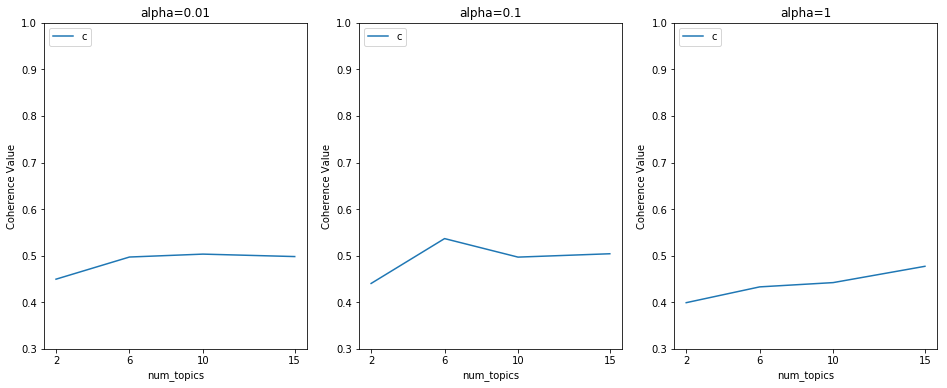

In [22]:
# plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

        
# plot
plot_coherence(coherence_df, alpha_range, num_topics_range)

In [23]:
# Build LDA model with alpha=0.1 and 10 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1,
                                           per_word_topics=True)

In [24]:
# print keywords 
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.121*"love" + 0.114*"demonetization" + 0.065*"successful" + 0.064*"wave" + '
  '0.054*"index" + 0.042*"effect" + 0.042*"economy" + 0.028*"industrial" + '
  '0.028*"contract" + 0.028*"double"'),
 (1,
  '0.130*"demonetization" + 0.116*"will" + 0.086*"dear" + 0.072*"due" + '
  '0.060*"there" + 0.054*"people" + 0.042*"money" + 0.026*"production" + '
  '0.025*"already" + 0.024*"flag"'),
 (2,
  '0.161*"demonetization" + 0.105*"video" + 0.100*"question" + '
  '0.091*"fisherman" + 0.070*"amp" + 0.044*"slip" + 0.043*"youtubeisdead" + '
  '0.043*"offensive" + 0.022*"can" + 0.020*"lose"'),
 (3,
  '0.130*"cash" + 0.087*"make" + 0.061*"demonetization" + 0.048*"help" + '
  '0.034*"watch" + 0.023*"month" + 0.022*"payment" + 0.021*"post" + '
  '0.019*"mandate" + 0.019*"poverty"'),
 (4,
  '0.100*"poor" + 0.094*"quiet" + 0.094*"englis" + 0.094*"men" + '
  '0.094*"prohibition" + 0.064*"demonetization" + 0.042*"believe" + '
  '0.042*"action" + 0.041*"reflect" + 0.039*"transparent"'),
 (5,
  '0.10

In [25]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5317069003889515


In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/yamshee/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.135073  0.004080       1        1  14.821146
6      0.137684  0.012399       2        1  14.805804
8      0.157359  0.005155       3        1  11.913087
5     -0.168226 -0.383450       4        1  11.634279
3     -0.029742  0.068028       5        1  10.929117
2      0.094190  0.032860       6        1   9.209536
0      0.105978  0.014661       7        1   8.716821
4      0.017029 -0.040027       8        1   6.749440
9     -0.294746  0.180230       9        1   5.695670
7     -0.154598  0.106065      10        1   5.525101, topic_info=     Category          Freq            Term         Total  loglift  logprob
607   Default   1601.000000            keep   1601.000000  30.0000  30.0000
80    Default   1450.000000            good   1450.000000  29.0000  29.0000
630   Default   1580.000000            will   1580.000000  28.0000  28.0000
719   Default   1570.000000       implement   1570.000000  27.0000  27.0000
15    Default   1314.000000            cash   1314.000000  26.0000  26.0000
1370  Default   1507.000000        actually   1507.000000  25.0000  25.0000
750   Default   1320.000000            find   1320.000000  24.0000  24.0000
1726  Default    932.000000           blame    932.000000  23.0000  23.0000
1301  Default    866.000000            modi    866.000000  22.0000  22.0000
1426  Default    973.000000            love    973.000000  21.0000  21.0000
143   Default   1083.000000             ban   1083.000000  20.0000  20.0000
74    Default    805.000000           prove    805.000000  19.0000  19.0000
744   Default   1175.000000            dear   1175.000000  18.0000  18.0000
466   Default    895.000000           video    895.000000  17.0000  17.0000
1715  Default    702.000000        economic    702.000000  16.0000  16.0000
9     Default    850.000000        question    850.000000  15.0000  15.0000
450   Default    879.000000            make    879.000000  14.0000  14.0000
30    Default    894.000000               s    894.000000  13.0000  13.0000
237   Default    987.000000             due    987.000000  12.0000  12.0000
5132  Default    772.000000       fisherman    772.000000  11.0000  11.0000
110   Default    621.000000            poor    621.000000  10.0000  10.0000
458   Default    871.000000              ad    871.000000   9.0000   9.0000
1642  Default    584.000000           quiet    584.000000   8.0000   8.0000
5217  Default    583.000000             men    583.000000   7.0000   7.0000
5218  Default    583.000000     prohibition    583.000000   6.0000   6.0000
5216  Default    583.000000          englis    583.000000   5.0000   5.0000
2944  Default    823.000000           there    823.000000   4.0000   4.0000
3     Default  10616.000000  demonetization  10616.000000   3.0000   3.0000
1101  Default    668.000000          supply    668.000000   2.0000   2.0000
0     Default    597.000000             amp    597.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
4954  Topic10    153.629608          finger    154.941818   2.8874  -3.5010
4953  Topic10    153.629608           cross    154.941818   2.8874  -3.5010
1510  Topic10     89.249710             buy     90.142487   2.8859  -4.0442
297   Topic10     76.429070            read     77.321846   2.8843  -4.1992
121   Topic10     69.641991          oppose     70.534912   2.8831  -4.2922
299   Topic10     67.657784           story     68.550468   2.8828  -4.3211
2220  Topic10     65.505325        analysis     66.398033   2.8823  -4.3535
620   Topic10     64.143822            rule     65.036560   2.8820  -4.3745
2111  Topic10     58.779190      technology     59.671890   2.8808  -4.4618
3171  Topic10     54.213280         inspire     55.106003   2.8795  -4.5427
2326  Topic10     45.638691      demonetize     46.531410   2.8765  -4.7148
3521  Topic10     40.977951         produ